+# Imports

In [593]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [594]:
df = pd.read_csv('../data/df_ph.csv',sep = ',')

# Encoding

In [595]:
df['Motif'] = df['Motif'].apply(lambda x : 3 if x == 'Motif tres mauvais' else 2 if x == 'Motif mauvais' else 1)

df['Situation_fam'] = df['Situation_fam'].apply(lambda x : 2 if x == 'Mauvaise situation' else 1)

df['Nature'] = df['Nature'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['Solution_echec'] = df['Solution_echec'].apply(lambda x : 2 if x == 'Mauvaise solution' else 1)

df['Nature_op'] = df['Nature_op'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['MTF'] = df['MTF'].apply(lambda x : 2 if x == 'Mauvais MTF' else 1)

df['ETAT_CIVIL'] = df['ETAT_CIVIL'].apply(lambda x : 2 if x == 'Mauvais etat' else 1)

df['CSP'] = df['CSP'].apply(lambda x : 2 if x == 'Mauvaise CSP' else 1)

df['nb_empr_ope'] = df['nb_empr_ope'].apply(lambda x : 1 if x == 'Un emprunteur' else 2)

# Feature selection

In [596]:
df = df[[ 'MTF', 'dls_mep_entree_def',
       'ANC_PRO_MAX_PFI', 'nb_empr_ope',
        'MT_REST_VIVRE', 'DET', 'arrete', 'cd_op', 'date_entree_defaut']]

In [597]:
df['nb_empr_ope'].value_counts()

nb_empr_ope
2    13383
1     9310
Name: count, dtype: int64

In [598]:
df.select_dtypes(include = 'float').columns

Index(['dls_mep_entree_def', 'ANC_PRO_MAX_PFI', 'MT_REST_VIVRE'], dtype='object')

In [599]:
df['arrete'] = pd.to_datetime(df['arrete']) 
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut']) 

# Train validation split

In [600]:
df_validation = df[df['arrete']>"2020-12-30"]

In [601]:
data = df[df['arrete']<"2020-12-30"]

# Data prep for cox model

In [602]:
data_haz = data.copy()
data_test =df_validation.copy()

In [603]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [604]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))


data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [605]:
data_haz.id = data_haz.id.astype('int')

In [606]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    'DET'], 'stop'] = 0.5 

In [607]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

data_test = data_test.select_dtypes(exclude=["datetime64"])

In [608]:
data_haz.drop(columns = ["cd_op"], inplace = True)


data_test.drop(columns = ["cd_op"], inplace = True)

In [609]:
data_haz.shape

(12461, 9)

In [610]:
data_haz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12461 entries, 0 to 22543
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MTF                 12461 non-null  int64  
 1   dls_mep_entree_def  12461 non-null  float64
 2   ANC_PRO_MAX_PFI     12461 non-null  float64
 3   nb_empr_ope         12461 non-null  int64  
 4   MT_REST_VIVRE       12461 non-null  float64
 5   DET                 12461 non-null  int64  
 6   start               12461 non-null  int64  
 7   stop                12461 non-null  float64
 8   id                  12461 non-null  int32  
dtypes: float64(4), int32(1), int64(4)
memory usage: 924.8 KB


# Modelisation

In [611]:
data_test.drop(columns = ['start','DET', 'id'],inplace = True )

In [612]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)  # Choisir le paramètre de pénalité
cph.fit(data_haz.drop(columns = ['id','start']), duration_col='stop', event_col='DET')


<lifelines.CoxPHFitter: fitted with 12461 total observations, 7617 right-censored observations>

In [613]:
predictions = cph.predict_survival_function(data_test)


In [614]:
predictions = predictions.transpose()

In [615]:
predictions.shape

(10232, 1146)

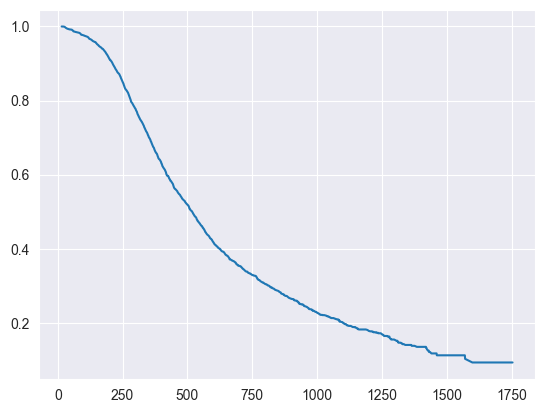

In [616]:
survival_function_observation_0 = predictions.iloc[46]

# Tracer la fonction de survie pour l'observation 0
survival_function_observation_0.plot()
plt.show()

In [617]:
cph.check_assumptions(data_haz.drop(columns = ['id','start']))

Proportional hazard assumption looks okay.


[]

In [618]:
cph.AIC_partial_

80369.28346718455

In [619]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 12461 total observations, 7617 right-censored observations>
             duration col = 'stop'
                event col = 'DET'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 12461
number of events observed = 4844
   partial log-likelihood = -40179.64
         time fit was run = 2024-02-05 22:48:32 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
MTF                  1.09       2.97       0.06             0.96             1.22                 2.62                 3.37
dls_mep_entree_def  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ANC_PRO_MAX_PFI     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
nb_empr_ope         -0.19       0.83       0.03            -0.24            -0.13                 0.79                 0.87
MT_REST_VIVRE       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                     cmp to     z      p   -log2(p)
covariate                                          
MTF                    0.00 17.03 <0.005     213.71
dls_mep_entree_def     0.00 -0.84   0.40       1.32
ANC_PRO_MAX_PFI        0.00 -3.42 <0.005      10.64
nb_empr_ope            0.00 -7.09 <0.005      39.39
MT_REST_VIVRE          0.00 -1.74   0.08       3.60
---
Concordance = 0.58
Partial AIC = 80369.28
log-likelihood ratio test = 439.53 on 5 df
-log2(p) of ll-ratio test = 305.79

In [620]:
df.shape

(22693, 9)

In [621]:
data_haz.columns

Index(['MTF', 'dls_mep_entree_def', 'ANC_PRO_MAX_PFI', 'nb_empr_ope',
       'MT_REST_VIVRE', 'DET', 'start', 'stop', 'id'],
      dtype='object')

In [628]:
data_haz['dls_mep_entree_def'].mean()

87.76630821495718

<Axes: >

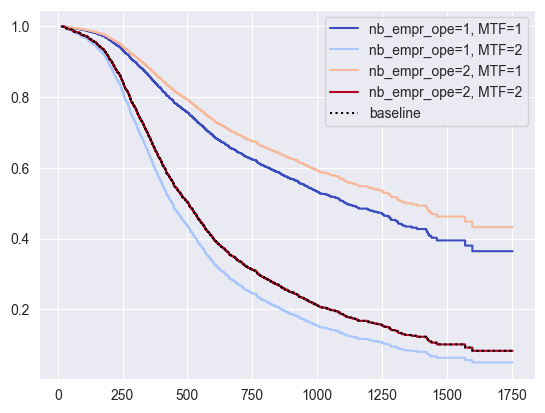

In [623]:
cph.plot_partial_effects_on_outcome(['nb_empr_ope','MTF'], values=[ [1,  1], [1,  2], [2, 1], [2,  2]], cmap='coolwarm')

<Axes: >

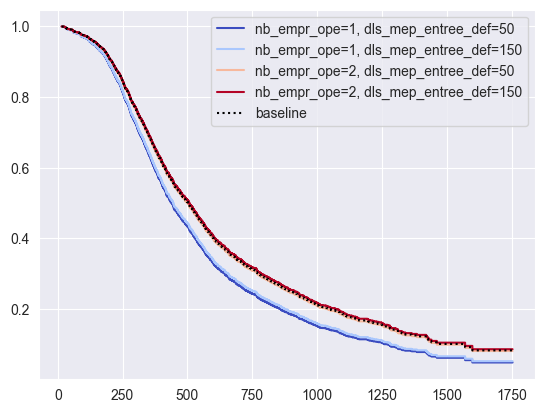

In [629]:
cph.plot_partial_effects_on_outcome(['nb_empr_ope','dls_mep_entree_def'], values=[ [1,  50], [1,  150], [2, 50], [2,  150]], cmap='coolwarm')